# DACON : 숫자 음성 데이터 분류

https://dacon.io/competitions/official/235905/overview/description

0~9까지 말하는 음성데이터 분류

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
import sklearn
from tqdm.notebook import tqdm
import librosa
import librosa.display
import IPython.display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## 1. 데이터 확인

In [2]:
y, sr = librosa.load('./data/train/001.wav')
IPython.display.Audio(data=y, rate=sr)

In [3]:
df = pd.read_csv('./data/train.csv')
df

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0
...,...,...
395,594.wav,8
396,595.wav,5
397,597.wav,9
398,598.wav,3


## 2. 데이터 전처리

In [4]:
def get_mfcc(mfccs):
    df_mfcc = pd.DataFrame()
    # 빈 리스트 생성
    for i in range(mfccs.shape[0]):
        globals()[f'mfcc_mean_list_{i+1}'] = []
        globals()[f'mfcc_var_list_{i+1}'] = []

    # mfcc 20개 각 평균, 분산 구하기
    for i in range(mfccs.shape[0]):
        globals()[f'mfcc_mean_{i+1}'] = mfccs[i].mean()
        globals()[f'mfcc_var_{i+1}'] = mfccs[i].var()

        # 리스트에 담기
        globals()[f'mfcc_mean_list_{i+1}'].append(globals()[f'mfcc_mean_{i+1}'])
        globals()[f'mfcc_var_list_{i+1}'].append(globals()[f'mfcc_var_{i+1}'])

    # 데이터프레임으로 만들기
    for i in range(mfccs.shape[0]):
        df_mfcc[f'mm{i}'] = globals()[f'mfcc_mean_list_{i+1}']
        df_mfcc[f'mv{i}'] = globals()[f'mfcc_var_list_{i+1}']
        
    return df_mfcc

In [5]:
def get_wav(file_path):
    df = pd.DataFrame()
    df_mfcc_all = pd.DataFrame()
    y_mean_list = []
    y_var_list = []
    D_mean_list = []
    D_var_list = []
    yf_mean_list = []
    yf_var_list = []
    DB_mean_list = []
    DB_var_list = []
    S_mean_list = []
    S_var_list = []
    S_DB_mean_list = []
    S_DB_var_list = []
    harm_mean_list = []
    harm_var_list = []
    perc_mean_list = []
    perc_var_list = []
    mfcc_mean_list = []
    mfcc_var_list = []
    chroma_mean_list = []
    chroma_var_list = []
    file_name_list = []

    for i in tqdm(file_path):
        # 데이터 로드
        y, sr = librosa.load(i)
        y_mean = np.mean(y)
        y_var = np.var(y)

        # stft
        D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
        D_mean = np.mean(D)
        D_var = np.var(D)

        # fft
        yf = np.fft.fft(y)
        yf = abs(yf)
        xf = np.linspace(0, sr, len(yf))
        plt_yf = yf[:int(len(yf)/2)]
        plt_xf = xf[:int(len(yf)/2)]
        yf_mean = np.mean(yf)
        yf_var = np.var(yf)

        # db
        DB = librosa.amplitude_to_db(D, ref=np.max) #amplitude(진폭) -> DB(데시벨)로 바꿔라
        DB_mean = np.mean(DB)
        DB_var = np.var(DB)

        # mel spectrogram
        S = librosa.feature.melspectrogram(y, sr=sr)
        S_DB = librosa.amplitude_to_db(S, ref=np.max)

        S_mean = np.mean(S)
        S_var = np.var(S)
        S_DB_mean = np.mean(S_DB)
        S_DB_var = np.var(S_DB)

        # harmonic, percussive
        y_harm, y_perc = librosa.effects.hpss(y)

        harm_mean = np.mean(y_harm)
        harm_var = np.var(y_harm)
        perc_mean = np.mean(y_perc)
        perc_var = np.var(y_perc)

        # mfcc
        mfccs = librosa.feature.mfcc(y, sr=sr)

        df_mfcc = get_mfcc(mfccs)
        df_mfcc_all = pd.concat([df_mfcc_all, df_mfcc])

        # chroma
        chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)
        chroma_mean = np.mean(chromagram)
        chroma_var = np.var(chromagram)

        y_mean_list.append(y_mean)
        y_var_list.append(y_var)
        D_mean_list.append(D_mean)
        D_var_list.append(D_var)
        yf_mean_list.append(yf_mean)
        yf_var_list.append(yf_var)
        DB_mean_list.append(DB_mean)
        DB_var_list.append(DB_var)
        S_mean_list.append(S_mean)
        S_var_list.append(S_var)
        S_DB_mean_list.append(S_DB_mean)
        S_DB_var_list.append(S_DB_var)
        harm_mean_list.append(harm_mean)
        harm_var_list.append(harm_var)
        perc_mean_list.append(perc_mean)
        perc_var_list.append(perc_var)
        chroma_mean_list.append(chroma_mean)
        chroma_var_list.append(chroma_var)
        file_name_list.append(i[-7:])
        
#         import pdb
#         pdb.set_trace()
        
    df_mfcc_all['file_name'] = file_name_list
    df['file_name'] = file_name_list
    df['y_mean'] = y_mean_list
    df['y_var'] = y_var_list
    df['D_mean'] = D_mean_list
    df['D_var'] = D_var_list
    df['yf_mean'] = yf_mean_list
    df['yf_var'] = yf_var_list
    df['DB_mean'] = DB_mean_list
    df['DB_var'] = DB_var_list
    df['S_mean'] = S_mean_list
    df['S_var'] = S_var_list
    df['S_DB_mean'] = S_DB_mean_list
    df['S_DB_var'] = S_DB_var_list
    df['harm_mean'] = harm_mean_list
    df['harm_var'] = harm_var_list
    df['perc_mean'] = perc_mean_list
    df['perc_var'] = perc_var_list
    df['chroma_mean'] = chroma_mean_list
    df['chroma_var'] = chroma_var_list  
    df_mfcc_all['file_name'] = file_name_list

    df = df.reset_index(drop=True)
    df = pd.merge(df, df_mfcc_all, how='left', on='file_name')

    return df

In [6]:
def get_train_label(df):
    df_label = pd.read_csv('./data/train.csv')
    df = pd.merge(df, df_label, on='file_name')
    
    return df

In [7]:
def data_split(df):
    scaler = MinMaxScaler()

    X = df.drop(['label', 'file_name'], axis=1)
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=['y_mean', 'y_var', 'D_mean', 'D_var', 'yf_mean', 'yf_var',
                                 'DB_mean', 'DB_var', 'S_mean', 'S_var', 'S_DB_mean', 'S_DB_var',
                                 'harm_mean', 'harm_var', 'perc_mean', 'perc_var', 'chroma_mean',
                                 'chroma_var', 'mm0', 'mv0', 'mm1', 'mv1', 'mm2', 'mv2', 'mm3', 'mv3',
                                 'mm4', 'mv4', 'mm5', 'mv5', 'mm6', 'mv6', 'mm7', 'mv7', 'mm8', 'mv8',
                                 'mm9', 'mv9', 'mm10', 'mv10', 'mm11', 'mv11', 'mm12', 'mv12', 'mm13',
                                 'mv13', 'mm14', 'mv14', 'mm15', 'mv15', 'mm16', 'mv16', 'mm17', 'mv17',
                                 'mm18', 'mv18', 'mm19', 'mv19'])
    y = df['label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)
    return X_train, X_val, y_train, y_val

## 실행

In [8]:
if __name__ == '__main__':
    train_path = glob.glob('./data/train/*.wav')
    test_path = glob.glob('./data/test/*.wav')
    df_train = get_wav(train_path)
    df_test = get_wav(test_path)
    df_train = get_train_label(df_train)
    X_train, X_val, y_train, y_val = data_split(df_train)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
df_train

,file_name,y_mean,y_var,D_mean,D_var,yf_mean,yf_var,DB_mean,DB_var,S_mean,...,mv15,mm16,mv16,mm17,mv17,mm18,mv18,mm19,mv19,label
0,249.wav,-0.000008,0.000004,0.008078,0.002924,0.055277,0.046687,-64.127022,168.609146,0.000916,...,91.531593,-0.452880,26.894451,5.461998,87.881065,-0.316609,14.930370,1.131733,30.323616,4
1,513.wav,-0.000024,0.000042,0.028063,0.030468,0.178651,0.552019,-66.499695,228.346466,0.009401,...,41.993916,-11.846017,74.675171,0.515297,67.080704,-7.246839,48.582176,2.992514,26.609659,0
2,507.wav,-0.000012,0.000002,0.008716,0.001692,0.054466,0.030062,-57.814957,171.280655,0.000528,...,38.536644,-6.508096,21.753786,-5.628709,77.995628,-6.021202,73.371078,-1.203605,40.313477,7
3,261.wav,-0.000025,0.000015,0.034175,0.010312,0.236914,0.166051,-56.330338,222.962112,0.002728,...,17.614784,-2.902001,36.623047,5.089703,33.980709,6.776956,22.123289,3.959013,22.342098,6
4,077.wav,-0.000016,0.000068,0.040266,0.049955,0.259776,0.896187,-58.960064,181.851074,0.015569,...,8.026532,-12.249372,52.208462,-0.715709,17.939295,-6.040432,46.721340,7.695418,10.347543,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,244.wav,-0.000019,0.000005,0.016054,0.003461,0.111368,0.049642,-56.138390,210.908218,0.000950,...,59.122581,-8.842117,30.974899,9.367385,22.132885,-5.363334,41.412910,-1.449740,24.016075,8
396,536.wav,-0.000032,0.000008,0.017535,0.005839,0.143785,0.114379,-59.205143,210.988800,0.001735,...,82.646484,-1.549018,29.291620,7.329239,37.636169,-7.149328,41.638016,3.545225,46.187298,6
397,250.wav,-0.000029,0.000021,0.019833,0.015601,0.132425,0.238032,-68.729187,223.384735,0.004848,...,64.296722,-8.284435,36.266094,-4.184534,32.407242,-4.586468,31.684969,-4.158057,33.427937,1
398,287.wav,-0.000019,0.000008,0.014712,0.006215,0.112140,0.129044,-62.935101,196.534927,0.001864,...,26.233055,2.131415,17.600115,-1.986752,51.029877,-4.129436,42.491150,6.868384,22.441984,3


In [10]:
scaler = MinMaxScaler()

X = df_train.drop(['label', 'file_name'], axis=1)
X
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=['y_mean', 'y_var', 'D_mean', 'D_var', 'yf_mean', 'yf_var',
#                      'DB_mean', 'DB_var', 'S_mean', 'S_var', 'S_DB_mean', 'S_DB_var',
#                      'harm_mean', 'harm_var', 'perc_mean', 'perc_var', 'chroma_mean',
#                      'chroma_var', 'mm0', 'mv0', 'mm1', 'mv1', 'mm2', 'mv2', 'mm3', 'mv3',
#                      'mm4', 'mv4', 'mm5', 'mv5', 'mm6', 'mv6', 'mm7', 'mv7', 'mm8', 'mv8',
#                      'mm9', 'mv9', 'mm10', 'mv10', 'mm11', 'mv11', 'mm12', 'mv12', 'mm13',
#                      'mv13', 'mm14', 'mv14', 'mm15', 'mv15', 'mm16', 'mv16', 'mm17', 'mv17',
#                      'mm18', 'mv18', 'mm19', 'mv19'])
# y = df['label']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

,y_mean,y_var,D_mean,D_var,yf_mean,yf_var,DB_mean,DB_var,S_mean,S_var,...,mm15,mv15,mm16,mv16,mm17,mv17,mm18,mv18,mm19,mv19
0,-0.000008,0.000004,0.008078,0.002924,0.055277,0.046687,-64.127022,168.609146,0.000916,0.000054,...,8.271572,91.531593,-0.452880,26.894451,5.461998,87.881065,-0.316609,14.930370,1.131733,30.323616
1,-0.000024,0.000042,0.028063,0.030468,0.178651,0.552019,-66.499695,228.346466,0.009401,0.003759,...,8.705841,41.993916,-11.846017,74.675171,0.515297,67.080704,-7.246839,48.582176,2.992514,26.609659
2,-0.000012,0.000002,0.008716,0.001692,0.054466,0.030062,-57.814957,171.280655,0.000528,0.000015,...,9.767175,38.536644,-6.508096,21.753786,-5.628709,77.995628,-6.021202,73.371078,-1.203605,40.313477
3,-0.000025,0.000015,0.034175,0.010312,0.236914,0.166051,-56.330338,222.962112,0.002728,0.001420,...,8.947958,17.614784,-2.902001,36.623047,5.089703,33.980709,6.776956,22.123289,3.959013,22.342098
4,-0.000016,0.000068,0.040266,0.049955,0.259776,0.896187,-58.960064,181.851074,0.015569,0.019612,...,8.465655,8.026532,-12.249372,52.208462,-0.715709,17.939295,-6.040432,46.721340,7.695418,10.347543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000019,0.000005,0.016054,0.003461,0.111368,0.049642,-56.138390,210.908218,0.000950,0.000040,...,6.023321,59.122581,-8.842117,30.974899,9.367385,22.132885,-5.363334,41.412910,-1.449740,24.016075
396,-0.000032,0.000008,0.017535,0.005839,0.143785,0.114379,-59.205143,210.988800,0.001735,0.000639,...,8.718227,82.646484,-1.549018,29.291620,7.329239,37.636169,-7.149328,41.638016,3.545225,46.187298
397,-0.000029,0.000021,0.019833,0.015601,0.132425,0.238032,-68.729187,223.384735,0.004848,0.000933,...,4.201577,64.296722,-8.284435,36.266094,-4.184534,32.407242,-4.586468,31.684969,-4.158057,33.427937
398,-0.000019,0.000008,0.014712,0.006215,0.112140,0.129044,-62.935101,196.534927,0.001864,0.000496,...,5.599958,26.233055,2.131415,17.600115,-1.986752,51.029877,-4.129436,42.491150,6.868384,22.441984


## 4. 모델링

In [11]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import *

In [12]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGB Classifier': XGBClassifier(),
    'LGBM Classifier': LGBMClassifier()
}

In [13]:
# 성능 결과 비교를 위해 값을 넣어줄 변수 생성
model_list = []
time_list = []
accuracy_list = []
f1_list = []
recall_list = []
auc_list = []

In [14]:
for clf_name, clf in tqdm(classifiers.items()):
    # 모델 학습
    t0 = time() # 모델링 시작 시간
    clf.fit(X_train, y_train)
    
    # 모델 예측
    y_pred = clf.predict(X_val)
    t1 = time() # 모델링 끝난 시간
    duration = round(t1 - t0, ndigits=4)
    time_list.append(duration)
    
    accuracy = round(accuracy_score(y_val, y_pred), ndigits=3)
    accuracy_list.append(accuracy)

    f1 = round(f1_score(y_val, y_pred, average='micro'), ndigits=3)
    f1_list.append(f1)
    
    recall = round(recall_score(y_val, y_pred, average='micro'), ndigits=3)
    recall_list.append(recall)

#     auc = round(roc_auc_score(y_val, y_pred, multi_class='ovo'), ndigits=3)
#     auc_list.append(auc)
    
    model_list.append(clf_name)

  0%|          | 0/7 [00:00<?, ?it/s]

[11:06:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
result = pd.DataFrame({'Excution_time': time_list,
                       'Accuracy': accuracy_list,
                       'f1_Score': f1_list,
                       'Recall' : recall_list,
#                        'ROC_AUC': auc_list
                      }, index=model_list)
result

,Excution_time,Accuracy,f1_Score,Recall
Logistic Regression,0.0451,0.755,0.755,0.755
SVM,0.0151,0.745,0.745,0.745
KNN,0.0087,0.700,0.700,0.700
Decision Tree,0.0090,0.570,0.570,0.570
Random Forest,0.1627,0.750,0.750,0.750
XGB Classifier,0.1810,0.695,0.695,0.695
LGBM Classifier,0.1832,0.720,0.720,0.720


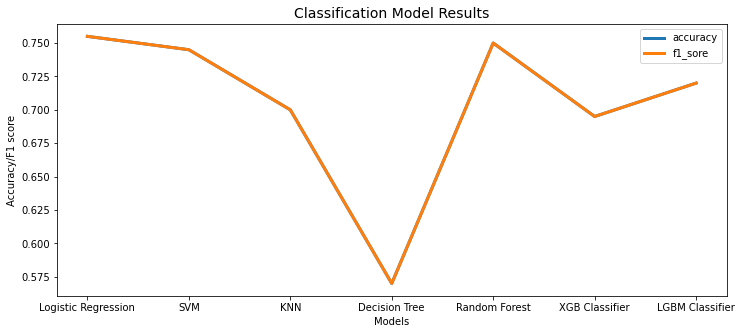

In [16]:
plt.figure(figsize=(12,5))
sns.lineplot(x=model_list, y=accuracy_list, linewidth=3, label='accuracy')
sns.lineplot(x=model_list, y=f1_list, linewidth=3, label='f1_sore')

plt.title('Classification Model Results', fontsize=14)
plt.xlabel('Models')
plt.ylabel('Accuracy/F1 score')
plt.legend(loc='upper right')

In [47]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred

array([3, 2, 4, 2, 8, 7, 8, 5, 9, 6, 3, 2, 9, 7, 6, 6, 6, 5, 6, 7, 2, 1,
       1, 4, 9, 9, 5, 6, 6, 1, 2, 5, 7, 3, 8, 1, 6, 0, 4, 6, 8, 3, 4, 9,
       4, 7, 9, 2, 4, 3, 8, 8, 9, 0, 6, 0, 5, 0, 3, 2, 8, 8, 3, 2, 3, 4,
       7, 2, 7, 6, 7, 5, 9, 4, 3, 4, 7, 8, 3, 3, 5, 1, 3, 8, 6, 6, 4, 9,
       8, 1, 2, 2, 8, 3, 7, 1, 3, 4, 7, 8, 3, 3, 9, 2, 3, 1, 8, 0, 4, 4,
       5, 2, 9, 6, 2, 5, 4, 3, 8, 8, 4, 1, 2, 2, 3, 5, 4, 6, 6, 2, 2, 6,
       3, 2, 5, 9, 6, 9, 9, 4, 3, 3, 1, 2, 3, 2, 1, 9, 6, 5, 6, 3, 4, 7,
       4, 8, 6, 5, 1, 7, 9, 5, 3, 7, 8, 7, 1, 4, 5, 9, 1, 1, 5, 7, 1, 6,
       5, 7, 5, 6, 4, 0, 7, 0, 4, 4, 1, 1, 9, 6, 7, 3, 5, 2, 7, 8, 8, 0,
       5, 2])

In [48]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_val, y_pred)
print(cf)

[[ 8  3  3  5  3  0  0  2  0  2]
 [ 0 12  1  0  0  0  0  0  0  4]
 [ 0  0 14  1  0  0  1  0  0  0]
 [ 0  0  1 16  0  0  0  0  2  0]
 [ 0  0  0  0 17  1  0  0  0  0]
 [ 0  1  0  0  2 17  0  0  1  0]
 [ 0  0  0  0  0  0 21  0  0  0]
 [ 0  1  3  0  1  1  1 18  0  0]
 [ 0  0  0  3  0  1  1  0 17  0]
 [ 0  1  1  1  0  0  0  0  0 12]]


In [49]:
from sklearn.metrics import accuracy_score
print('예측 정확도 : ', accuracy_score(y_val, y_pred))

예측 정확도 :  0.76


In [50]:
df_test
X_test = df_test.drop('file_name', axis=1)
X_test = scaler.fit_transform(X_test)
X_test

array([[0.91257222, 0.04616945, 0.10449782, ..., 0.46939773, 0.51396376,
        0.05739011],
       [0.97056716, 0.03624624, 0.06014867, ..., 0.16488451, 0.55808893,
        0.29277168],
       [0.87291502, 0.0445163 , 0.05175469, ..., 0.17041004, 0.74717023,
        0.23864475],
       ...,
       [0.8621901 , 0.00633497, 0.02116491, ..., 0.09510307, 0.6715424 ,
        0.12790234],
       [0.9031039 , 0.02149247, 0.0547234 , ..., 0.46742095, 0.44606451,
        0.36664301],
       [0.90521898, 0.00952738, 0.04521045, ..., 0.34365659, 0.84775225,
        0.37514419]])

In [51]:
y_pred = model.predict(X_test)
result_df = pd.read_csv('./data/test.csv')
result_df['label'] = y_pred
result_df = result_df.sort_values('file_name')
result_df.to_csv('./data/sample_submission.csv', index=False)
result_df['label'].value_counts()

2    31
4    24
6    24
3    23
1    20
7    19
5    18
9    16
8    14
0    11
Name: label, dtype: int64

In [46]:
result_df

,file_name,label
0,003.wav,8
1,008.wav,4
2,010.wav,2
3,015.wav,0
4,024.wav,7
...,...,...
195,583.wav,6
196,589.wav,4
197,590.wav,1
198,596.wav,8
